In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} 

In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, Y.shape
# shape of the dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [6]:
C = torch.randn((27,2))
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

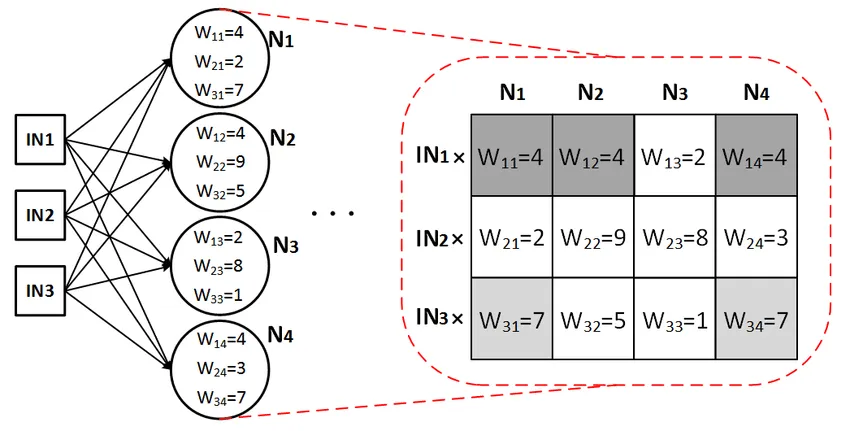

In [7]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [8]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [9]:
h.shape

torch.Size([228146, 100])

In [10]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [11]:
logits = h @ W2 + b2

In [12]:
logits.shape

torch.Size([228146, 27])

In [13]:
counts = logits.exp()

In [14]:
probs = counts / counts.sum(1, keepdims = True)

In [15]:
probs[torch.arange(53), Y] # we extract the "correct" probs

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [53], [228146]

In [82]:
loss = -probs[torch.arange(53), Y].log().mean()
loss

tensor(15.8883)

# Refactoring Code 

In [31]:
C = torch.randn((27,2))
W1 = torch.randn((6, 100))
b1 = torch.randn((100))
W2 = torch.randn((100, 27))
b2 = torch.randn((27))
parameters = [C, W1, b1, W2, b2]

In [32]:
[p.nelement() for p in parameters]

[54, 600, 100, 2700, 27]

In [33]:
sum([p.nelement() for p in parameters]) # total number of parameters

3481

In [34]:
for p in parameters:
    p.requires_grad = True

In [35]:
for _ in range(100):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward 
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # update
    for p in parameters: 
        p.data += -0.1 * p.grad
print(loss.item())

2.7378952503204346


# Mini Batch
- finding an optimal learning rate.
- 

In [21]:
torch.randint(0, X.shape[0], (32,))

tensor([ 51555,  66403,  45273, 130628, 213165,  34383, 136332,  84001, 217752,
        202355, 109965,  90530,   7874, 127905,  37093,  99944, 212224,  32240,
        171828, 151655,  47336,   8291,  16254,  18996,  23886, 120022, 205037,
         48736,  65959,  84480, 157544,  40954])

In [22]:
X.shape[0]

228146

In [36]:
lre = torch.linspace(-3, 0 ,1000)
lrs = 10**lre

In [39]:
lri = [] 
lossi = []
for i in range(1000):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward 
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters: 
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lossi.append(loss.item())
    
print(loss.item())

6.844985485076904


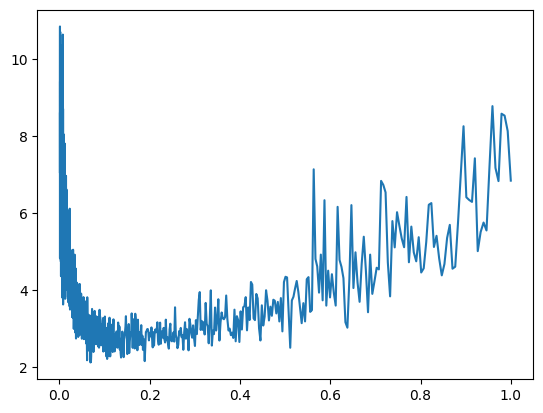

In [41]:
plt.plot(lri,  lossi)